In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import random
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [35]:
class ImageDataset(Dataset):
    """Dataset of Images and Labels"""

    def __init__(self, images, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = np.array(self.labels[idx])
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [36]:
class CNN(nn.Module):
    """
    Convolutional Neural Network for multiband data. Note that you
    will need to update the number of in_features for self.fc3.
    """
    def __init__(self, in_channels, num_classes):
        """
		Args:
		    in_channels: number of bands (gri = 3, griz=4)
			num_classes: number of unique labels in your dataset
		"""
        super(CNN, self).__init__()
        
        #Network Components
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=48, 
                               kernel_size=15, 
                               stride=3,
                               padding=2)

        self.conv2 = nn.Conv2d(in_channels=48, 
                               out_channels=96,
                               kernel_size=5, 
                               stride=1,
                               padding=2)
        
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(in_features=3456, 
                             out_features=408)

        self.fc2 = nn.Linear(in_features=408, 
                             out_features=25)

        self.fc3 = nn.Linear(in_features=25, 
                             out_features=num_classes)


    def forward(self, x):
        #Network Flow
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

    def init_weights(self, m):
        if (type(m) == nn.Linear or type(m) == nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [37]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors"""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
		
		# I like to add any scaling functions here, so uncomment if desired
		#image = (image - np.min(image, axis=(-1,-2))[:,:,np.newaxis,np.newaxis]) / np.max(image - np.min(image, axis=(-1,-2))[:,:,np.newaxis,np.newaxis], axis=(-1,-2))[:,:,np.newaxis,np.newaxis]

        return {'image': torch.from_numpy(image).float(),
                'label': torch.from_numpy(label)}

In [38]:
def make_train_test_datasets(images, labels, test_size=0.2, transform=ToTensor()):
    """
	Make training and testing datasets
	
	Args:
	    images: 4D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    print(len(images))
    # Shuffle and split data
    y = labels
    # Images
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_labels, transform=transform),
            ImageDataset(test_images, test_labels, transform=transform))

In [39]:
cnn = CNN(in_channels=3, num_classes=2)

In [40]:
name = '14/model.pt'
name_saved_model = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/models/exp/' + name #'model.pt'
cnn = torch.load(name_saved_model)

In [41]:
path_cutouts = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/real_lenses/cutouts/'
hdu_list = fits.open(path_cutouts + 'real_lenses.fits')
sim = hdu_list[1].data 
hdu_list.close()

In [42]:
print(sim.shape)

def make_plot_all(objects):
    plt.figure(figsize=(15,10))
    for i in range(20):
        plt.subplot(4,5,i+1)
        rgb = make_lupton_rgb(objects[i][2], objects[i][1], objects[i][0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.xticks([], [])
        plt.yticks([], [])
    #if(os.path.exists(path_im) == False):
    #        os.makedirs(path_im)
    #plt.savefig(path_im + '/' + title + '.png', bbox_inches='tight')
    plt.show()

(510, 3, 46, 46)


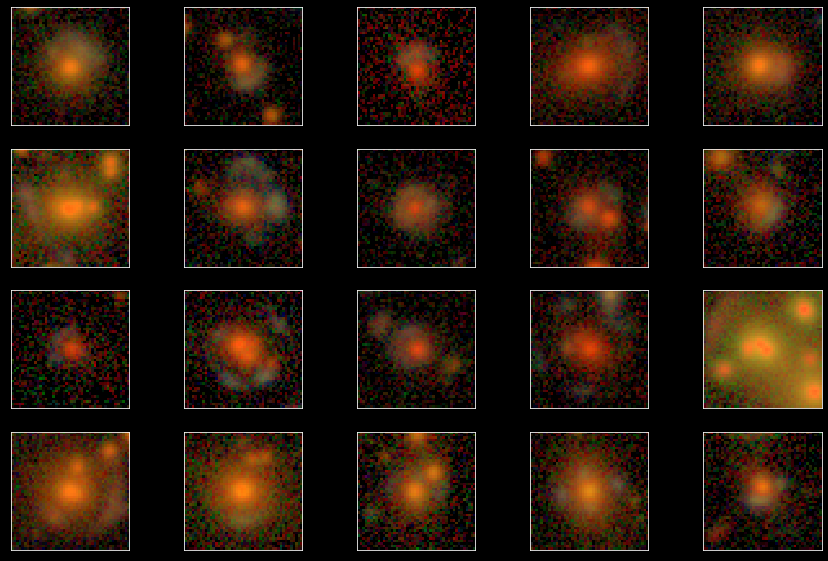

In [43]:
idx = random.sample(range(len(sim)), 20)
objects = sim[idx]
make_plot_all(objects)

In [44]:
images = sim.astype(np.float32)
labels = np.zeros(len(sim), dtype = np.int64)
train_dataset, test_dataset = make_train_test_datasets(images, labels, test_size=0.9)
print(len(test_dataset))

510
459


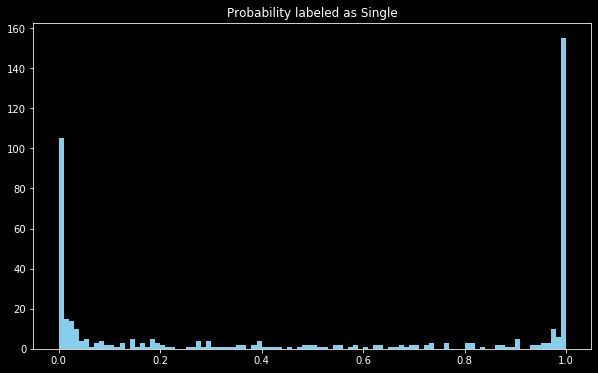

In [46]:
# Use the CNN to classify your whole test dataset
cnn.eval()
non_binary_predictions = cnn(test_dataset[:]['image'])

test_predictions = torch.max(cnn(test_dataset[:]['image']), 1)[1].data.numpy()  
test_labels = test_dataset[:]['label'].data.numpy()

m = nn.Softmax(dim=1) 
prob = (m(non_binary_predictions))
prob = prob[:,0].detach().numpy()

plt.figure(figsize=(10,6))
plt.title('Probability labeled as Single')
plt.hist(prob, 100, color = "skyblue")
#plt.savefig(path_im + '/' + 'Prob_Pos Distribution.png', bbox_inches='tight')
plt.show()

In [47]:
#get indices of test dataset where the label is wrong predicted
indices_w, indices_r = [], []
for i in range(len(test_labels)):
    if(test_predictions[i] != test_labels[i]):
        indices_w.append(i)
    else: 
        indices_r.append(i)

Wrong


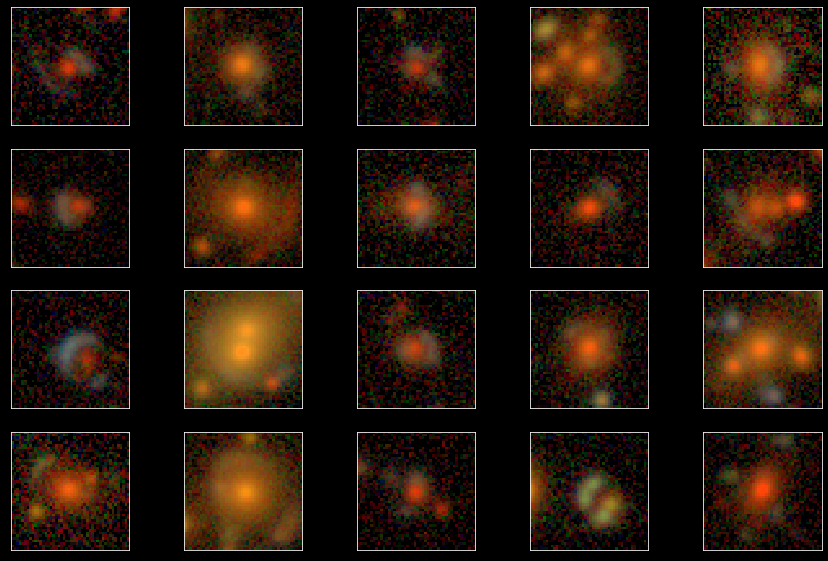

Right


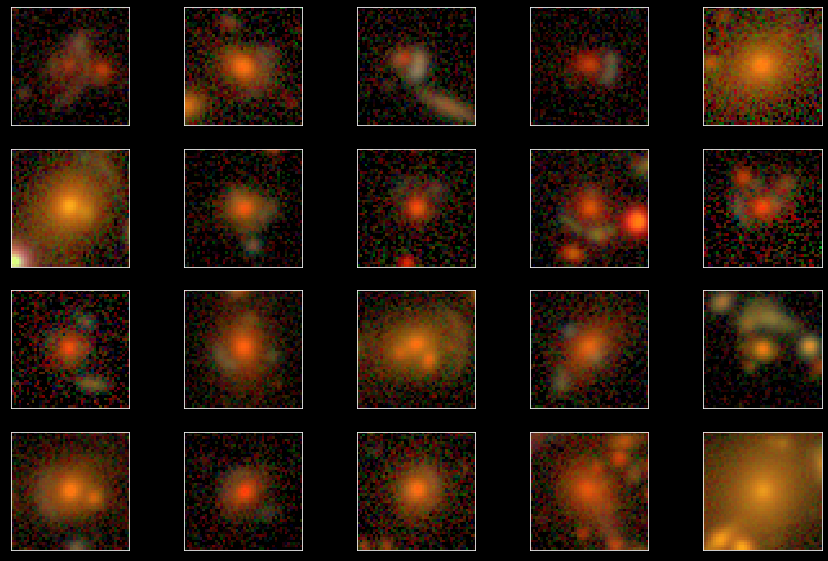

In [49]:
pre_wrong = sim[indices_w]
pre_right = sim[indices_r]

print('Wrong')
idx = random.sample(range(len(pre_wrong)), 20)
objects = pre_wrong[idx]
make_plot_all(objects)

print('Right')
idx = random.sample(range(len(pre_right)), 20)
objects = pre_right[idx]
make_plot_all(objects)